# Optimizing Nueral Network Architecture and Hyperparameters



# Setup for Neural Architecture Search (NAS)

The following demonstrates the training within an annotated function to support NAS.

In [1]:
from typing import Optional, Annotated, Union
from dataclasses import dataclass, field

import raxpy
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
 
# Load the California Housing Dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

@dataclass
class Layer:
    dropout:Annotated[float, raxpy.Float(lb=0.0, ub=0.9)]
    neuron_count:Annotated[int, raxpy.Integer(lb=8, ub=256)]
    activation_type:bool

    def create_layer(self, input_shape):
        parts = [
            Dense(self.neuron_count, activation='relu', input_shape=input_shape),
        ]

        if self.dropout > 0.0:
            parts.append(Dropout(self.dropout))  # Dropout for regularization
        return parts


@dataclass
class LearningRateScheduleFixed:
    learning_rate:Annotated[float, raxpy.Float(lb=0.0001,ub=0.01)] = 0.001

    def create(self):
        return self.learning_rate


@dataclass
class LearningRateScheduleExponentialDecay:
    initial_learning_rate:Annotated[float, raxpy.Float(lb=0.0001,ub=0.01)] = 0.001
    decay_steps:Annotated[float, raxpy.Integer(lb=100,ub=10000)]=1000,           # Decay every 1000 steps
    decay_rate:Annotated[float, raxpy.Float(lb=0.5,ub=0.99)]=0.96,            # Multiply by 0.96 at each decay step
    staircase:bool=True              # If True, decay in discrete steps

    def create(self):
        return tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=self.initial_learning_rate,
            decay_steps=self.decay_steps,
            decay_rate=self.decay_rate,
            staircase=self.staircase
        )
    


@dataclass
class OptimizerSGD:
    learning_rate_schedule:Union[LearningRateScheduleFixed, LearningRateScheduleExponentialDecay] = field(default_factory=LearningRateScheduleFixed)
    momentum:Annotated[float, raxpy.Float(lb=0.5,ub=0.95)] = 0.9       # Momentum factor for smoother convergence
    nesterov:bool = True       # Nesterov momentum for accelerated learning

    
    def create(self):
        return SGD(
            learning_rate=self.learning_rate_schedule.create(),
            momentum=self.momentum,
            nesterov=self.nesterov
        )


@dataclass
class OptimizerADAM:
    beta_1:Annotated[float, raxpy.Float(lb=0.8,ub=0.99)]=0.9           # Exponential decay rate for the 1st moment (mean of gradients)
    beta_2:Annotated[float, raxpy.Float(lb=0.8,ub=0.9999)]=0.999         # Exponential decay rate for the 2nd moment (variance of gradients)
    amsgrad:bool=False
    learning_rate_schedule:Union[LearningRateScheduleFixed, LearningRateScheduleExponentialDecay] = field(default_factory=LearningRateScheduleFixed)

    def create(self):
        return Adam(
            learning_rate=self.learning_rate_schedule.create(),
            beta_1=self.beta_1,
            beta_2=self.beta_2,
            epsilon=1e-07,# Small constant to prevent division by zero
            amsgrad=self.amsgrad
        )


def train(
    batch_size:Annotated[int, raxpy.Integer(value_set=[8,16,32,64])],
    scaler_flag:bool,
    layer_1:Layer,
    layer_2:Layer,
    layer_3:Optional[Layer],
    layer_4:Optional[Layer],
    optimizer:Union[OptimizerADAM,OptimizerSGD]
):
    # Standardize the data (important for neural networks)

    if scaler_flag:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    X_train_t = scaler.fit_transform(X_train)
    X_test_t = scaler.transform(X_test)

    c = layer_1.create_layer((X_train_t.shape[1],)) + layer_2.create_layer((layer_1.neuron_count,))
    p_count = layer_2.neuron_count
    if layer_3 is not None:
        c = c + layer_3.create_layer((p_count,))
        p_count = layer_3.neuron_count
    if layer_4 is not None:
        c = c + layer_4.create_layer((p_count,))
        p_count = layer_4.neuron_count

    c = c + [
        Dense(1)  # Output layer for regression
    ]
    # Define the ANN model
    model = Sequential(c)

    # Compile the model
    model.compile(optimizer=optimizer.create(), loss='mse', metrics=['mae'])


    # Set up early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',       # Monitor validation loss
        patience=5,              # Stop after 5 epochs with no improvement
        restore_best_weights=True # Restore model weights from the best epoch
    )

    # Train the model
    history = model.fit(X_train_t, y_train, validation_split=0.2, callbacks=[early_stopping], epochs=250, batch_size=batch_size, verbose=1)

    # Evaluate the model on the test set
    loss, mae = model.evaluate(X_test_t, y_test, verbose=0)
    print(f"Test Mean Absolute Error (MAE): {mae:.2f}")

    # Predict and calculate the Mean Squared Error
    y_pred = model.predict(X_test_t)
    try:
        mse = mean_squared_error(y_test, y_pred)
        print(f"Test Mean Squared Error (MSE): {mse:.2f}")
        # Plot training history
        import matplotlib.pyplot as plt

        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.show()
        
    except Exception as e:
        mse = np.inf
        print(f"Invalid Test Mean Squared Error (MSE)")
    
    return mse


2024-12-16 14:46:45.402306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734378405.419899  305669 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734378405.425364  305669 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 14:46:45.443456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Optuna Example

The following demonstrates using raxpy with Optuna.

In [2]:
import raxpy.adapters.optuna as raxpy_optuna
import optuna

/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def optimize(
        init_sampling_points:Annotated[int, raxpy.Integer(lb=0, ub=50)],
        designer,
        max_points=100,
        f=train,
    ):
    study = optuna.create_study()

    if init_sampling_points > 0:
        input_space = raxpy.function_spec.extract_input_space(f)
        design = designer(input_space, init_sampling_points)
        raxpy_optuna.enqueue_trials_from_doe_to_study(design, study)

    fn = raxpy_optuna.convert_to_optuna(f)

    study.optimize(fn, n_trials=max_points)

    return (study.best_params, fn)

[I 2024-12-16 14:46:47,268] A new study created in memory with name: no-name-0b3949c7-1008-4ca2-b9b9-bb72f3232bde
/home/neil/projects-alt/raxpy/raxpy/does/maxpro.py:183: RuntimeWarning: overflow encountered in scalar power
  p_threshold = math.e ** (-(d_try_value - d_best_value) / t)


Skipping dimensions
Skipping dimensions
Skipping dimensions
Skipping dimensions
Skipping dimensions
Skipping dimensions
Skipping dimensions
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new best!
Found new be

/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734378423.382979  305669 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1114 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6


Epoch 1/250


I0000 00:00:1734378424.644307  305994 service.cc:148] XLA service 0x7dcbf400b280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734378424.644332  305994 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-16 14:47:04.667805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734378424.743433  305994 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-16 14:47:06.003743: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1729', 500 bytes spill stores, 500 bytes spill loads

2024-12-16 14:47:06.168127: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1729', 444 by

  83/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1918 - mae: 1.1744

I0000 00:00:1734378427.721656  305994 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1652/1652 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 1.0699 - mae: 0.7866 - val_loss: 0.5795 - val_mae: 0.5886
Epoch 2/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6872 - mae: 0.6240 - val_loss: 0.5570 - val_mae: 0.5515
Epoch 3/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6253 - mae: 0.5946 - val_loss: 0.5377 - val_mae: 0.5366
Epoch 4/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6168 - mae: 0.5845 - val_loss: 0.5551 - val_mae: 0.5841
Epoch 5/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5716 - mae: 0.5678 - val_loss: 0.5305 - val_mae: 0.5118
Epoch 6/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5680 - mae: 0.5569 - val_loss: 0.5380 - val_mae: 0.5087
Epoch 7/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5476 - mae: 0.5488 - val_loss: 0.5083 - val_mae: 0.5080
Epoch 8/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5576 - mae: 0.5508 - val_loss: 0.5064 - val_mae: 0.5050
Epoch 9/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 

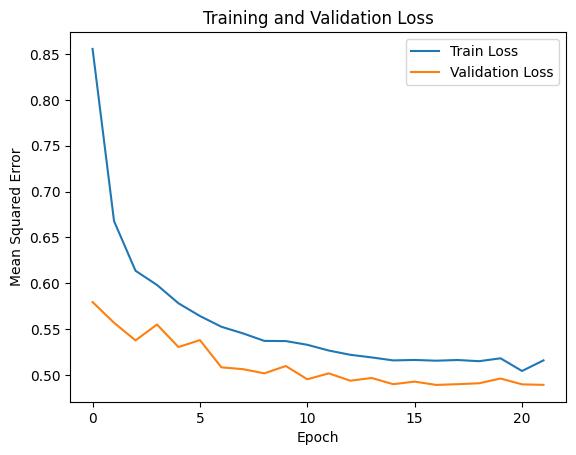

[I 2024-12-16 14:48:17,541] Trial 0 finished with value: 0.48572869917218514 and parameters: {'batch_size': 0, 'scaler_flag': 0, 'layer_1##dropout': 0.405, 'layer_1##neuron_count': 95, 'layer_1##activation_type': 1, 'layer_2##dropout': 0.405, 'layer_2##neuron_count': 169, 'layer_2##activation_type': 0, 'layer_3##NULL': 1.0, 'layer_3##dropout': 0.375, 'layer_3##neuron_count': 111, 'layer_3##activation_type': 0, 'layer_4##NULL': 1.0, 'layer_4##dropout': 0.375, 'layer_4##neuron_count': 153, 'layer_4##activation_type': 1, 'optimizer': 1, 'optimizer##option_1##learning_rate_schedule': 1, 'optimizer##option_1##learning_rate_schedule##option_1##initial_learning_rate': 0.0062875000000000006, 'optimizer##option_1##learning_rate_schedule##option_1##decay_steps': 3812.5, 'optimizer##option_1##learning_rate_schedule##option_1##decay_rate': 0.56125, 'optimizer##option_1##learning_rate_schedule##option_1##staircase': 0, 'optimizer##option_1##momentum': 0.7625, 'optimizer##option_1##nesterov': 0}. Be

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-16 14:48:20.125195: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1745', 444 bytes spill stores, 444 bytes spill loads

2024-12-16 14:48:20.202610: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1745', 500 bytes spill stores, 500 bytes spill loads



811/826 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2503 - mae: 0.8555

2024-12-16 14:48:24.076704: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1745', 444 bytes spill stores, 444 bytes spill loads

2024-12-16 14:48:24.393600: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1745', 500 bytes spill stores, 500 bytes spill loads



826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 1.2446 - mae: 0.8534 - val_loss: 0.7632 - val_mae: 0.7353
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7412 - mae: 0.6529 - val_loss: 0.5782 - val_mae: 0.5954
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6845 - mae: 0.6233 - val_loss: 0.7961 - val_mae: 0.6153
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6884 - mae: 0.6224 - val_loss: 0.5882 - val_mae: 0.5439
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6541 - mae: 0.6087 - val_loss: 0.5489 - val_mae: 0.5600
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6430 - mae: 0.5991 - val_loss: 0.6040 - val_mae: 0.5336
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6202 - mae: 0.5903 - val_loss: 0.5323 - val_mae: 0.5316
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6156 - mae: 0.5875 - val_loss: 0.5387 - val_mae: 0.5562
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - los

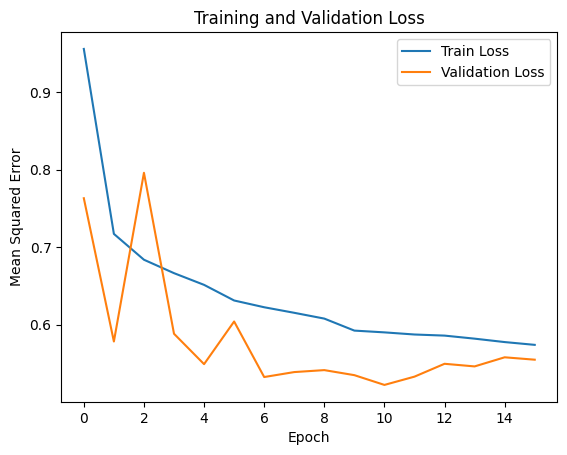

[I 2024-12-16 14:48:54,689] Trial 1 finished with value: 0.5205861502691042 and parameters: {'batch_size': 1, 'scaler_flag': 0, 'layer_1##dropout': 0.5850000000000001, 'layer_1##neuron_count': 120, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.225, 'layer_2##neuron_count': 95, 'layer_2##activation_type': 1, 'layer_3##NULL': 1.0, 'layer_3##dropout': 0.525, 'layer_3##neuron_count': 153, 'layer_3##activation_type': 1, 'layer_4##NULL': 1.0, 'layer_4##dropout': 0.525, 'layer_4##neuron_count': 111, 'layer_4##activation_type': 0, 'optimizer': 1, 'optimizer##option_1##learning_rate_schedule': 1, 'optimizer##option_1##learning_rate_schedule##option_1##initial_learning_rate': 0.0087625, 'optimizer##option_1##learning_rate_schedule##option_1##decay_steps': 6287.5, 'optimizer##option_1##learning_rate_schedule##option_1##decay_rate': 0.92875, 'optimizer##option_1##learning_rate_schedule##option_1##staircase': 1, 'optimizer##option_1##momentum': 0.6875, 'optimizer##option_1##nesterov': 1}. Be

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.2943 - mae: 1.0546 - val_loss: 0.7907 - val_mae: 0.6415
Epoch 2/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0207 - mae: 0.7395 - val_loss: 0.6877 - val_mae: 0.5911
Epoch 3/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8685 - mae: 0.6861 - val_loss: 0.7447 - val_mae: 0.6082
Epoch 4/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8202 - mae: 0.6617 - val_loss: 0.6369 - val_mae: 0.5656
Epoch 5/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7753 - mae: 0.6390 - val_loss: 0.7414 - val_mae: 0.6025
Epoch 6/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7376 - mae: 0.6192 - val_loss: 0.6191 - val_mae: 0.5537
Epoch 7/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6987 - mae: 0.6110 - val_loss: 0.5667 - val_mae: 0.5354
Epoch 8/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6779 - mae: 0.6011 - val_loss: 0.5967 - val_mae: 0.5420
Epoch 9/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

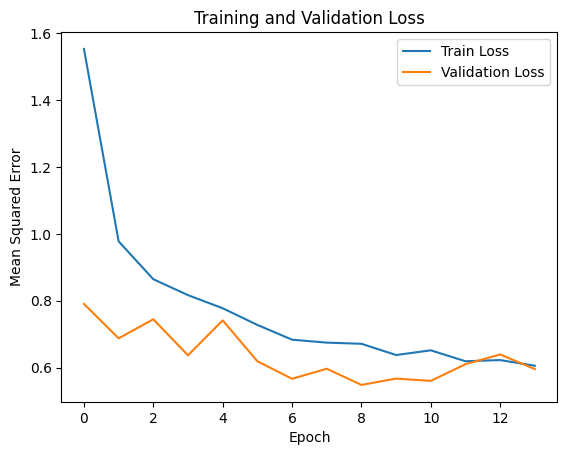

[I 2024-12-16 14:49:07,999] Trial 2 finished with value: 0.5209486096171019 and parameters: {'batch_size': 3, 'scaler_flag': 1, 'layer_1##dropout': 0.13500000000000004, 'layer_1##neuron_count': 45, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.7650000000000001, 'layer_2##neuron_count': 45, 'layer_2##activation_type': 0, 'layer_3##NULL': 1.0, 'layer_3##dropout': 0.675, 'layer_3##neuron_count': 70, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.96625, 'optimizer##option_0##beta_2': 0.8249875, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 0, 'optimizer##option_0##learning_rate_schedule##option_0##learning_rate': 0.007525000000000001}. Best is trial 0 with value: 0.48572869917218514.


Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1652/1652 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0436 - mae: 0.7604 - val_loss: 0.5551 - val_mae: 0.5524
Epoch 2/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6711 - mae: 0.6080 - val_loss: 0.5706 - val_mae: 0.5713
Epoch 3/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6320 - mae: 0.5882 - val_loss: 0.6102 - val_mae: 0.5690
Epoch 4/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5914 - mae: 0.5680 - val_loss: 0.5476 - val_mae: 0.5593
Epoch 5/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5814 - mae: 0.5702 - val_loss: 0.5847 - val_mae: 0.5670
Epoch 6/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5896 - mae: 0.5631 - val_loss: 0.6252 - val_mae: 0.5792
Epoch 7/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5836 - mae: 0.5640 - val_loss: 0.6537 - val_mae: 0.5576
Epoch 8/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5944 - mae: 0.5692 - val_loss: 0.6236 - val_mae: 0.5596
Epoch 9/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3

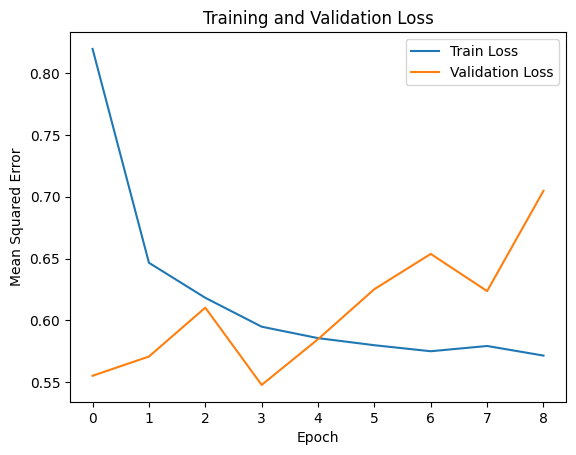

[I 2024-12-16 14:49:42,449] Trial 3 finished with value: 0.5344705683418659 and parameters: {'batch_size': 0, 'scaler_flag': 0, 'layer_1##dropout': 0.7650000000000001, 'layer_1##neuron_count': 244, 'layer_1##activation_type': 1, 'layer_2##dropout': 0.13500000000000004, 'layer_2##neuron_count': 219, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.0, 'layer_4##NULL': 1.0, 'layer_4##dropout': 0.075, 'layer_4##neuron_count': 28, 'layer_4##activation_type': 0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.82375, 'optimizer##option_0##beta_2': 0.9749125000000001, 'optimizer##option_0##amsgrad': 0, 'optimizer##option_0##learning_rate_schedule': 0, 'optimizer##option_0##learning_rate_schedule##option_0##learning_rate': 0.002575}. Best is trial 0 with value: 0.48572869917218514.


Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0020 - mae: 0.6928

2024-12-16 14:49:47.349463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 412 bytes spill stores, 444 bytes spill loads

2024-12-16 14:49:47.435004: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 404 bytes spill stores, 436 bytes spill loads

2024-12-16 14:49:49.585540: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 264 bytes spill stores, 264 bytes spill loads

2024-12-16 14:49:49.778749: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 204 bytes spill stores, 204 bytes spill loads



413/413 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.0012 - mae: 0.6925 - val_loss: 0.5501 - val_mae: 0.5066
Epoch 2/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5201 - mae: 0.5175 - val_loss: 0.4247 - val_mae: 0.4634
Epoch 3/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4871 - mae: 0.5053 - val_loss: 0.5099 - val_mae: 0.5237
Epoch 4/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4850 - mae: 0.4987 - val_loss: 0.4359 - val_mae: 0.4914
Epoch 5/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4828 - mae: 0.5030 - val_loss: 0.4387 - val_mae: 0.4989
Epoch 6/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5042 - mae: 0.4938 - val_loss: 0.4721 - val_mae: 0.4897
Epoch 7/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4721 - mae: 0.4964 - val_loss: 0.4466 - val_mae: 0.5206
Test Mean Absolute Error (MAE): 0.46
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test Mean Squared Error (MSE): 0.40


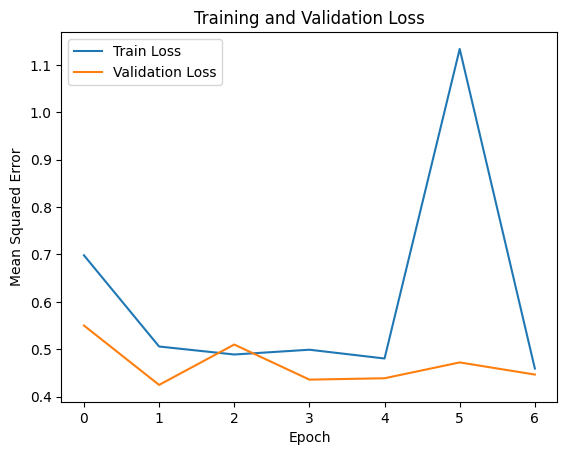

[I 2024-12-16 14:49:55,337] Trial 4 finished with value: 0.39953455550640343 and parameters: {'batch_size': 2, 'scaler_flag': 1, 'layer_1##dropout': 0.49500000000000005, 'layer_1##neuron_count': 194, 'layer_1##activation_type': 1, 'layer_2##dropout': 0.49500000000000005, 'layer_2##neuron_count': 144, 'layer_2##activation_type': 1, 'layer_3##NULL': 1.0, 'layer_3##dropout': 0.075, 'layer_3##neuron_count': 236, 'layer_3##activation_type': 0, 'layer_4##NULL': 0.0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.91875, 'optimizer##option_0##beta_2': 0.8749625000000001, 'optimizer##option_0##amsgrad': 0, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.007525000000000001, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 7525.0, 'optimizer##option_0##learning_rate_schedule##option_1##decay_rate': 0.6225, 'optimizer##option_0##learning_rate_schedule##option_1##staircase': 1}. Best is trial 

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7954 - mae: 0.9005

2024-12-16 14:50:01.230618: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 256 bytes spill stores, 256 bytes spill loads

2024-12-16 14:50:02.713368: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 264 bytes spill stores, 264 bytes spill loads



826/826 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.7948 - mae: 0.9004 - val_loss: 0.6295 - val_mae: 0.5447
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7857 - mae: 0.6437 - val_loss: 0.5448 - val_mae: 0.5106
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6556 - mae: 0.5835 - val_loss: 0.4904 - val_mae: 0.4843
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5966 - mae: 0.5551 - val_loss: 0.4459 - val_mae: 0.4548
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5762 - mae: 0.5425 - val_loss: 0.4661 - val_mae: 0.4663
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5404 - mae: 0.5283 - val_loss: 0.4135 - val_mae: 0.4456
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5352 - mae: 0.5227 - val_loss: 0.4330 - val_mae: 0.4534
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5136 - mae: 0.5100 - val_loss: 0.4415 - val_mae: 0.4630
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss:

2024-12-16 14:50:36.949467: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 404 bytes spill stores, 436 bytes spill loads



Test Mean Absolute Error (MAE): 0.43
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test Mean Squared Error (MSE): 0.36


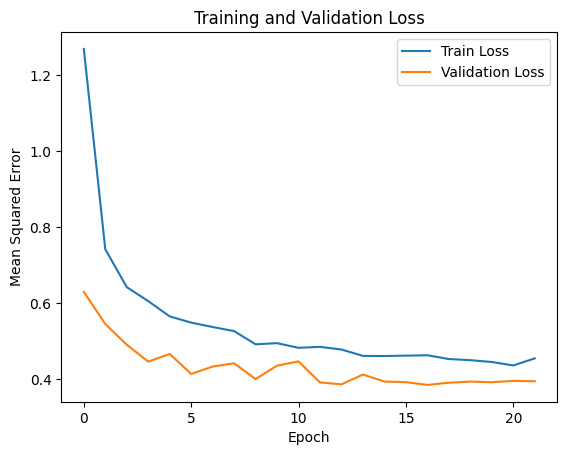

[I 2024-12-16 14:50:38,422] Trial 5 finished with value: 0.3594482541273132 and parameters: {'batch_size': 1, 'scaler_flag': 1, 'layer_1##dropout': 0.315, 'layer_1##neuron_count': 144, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.675, 'layer_2##neuron_count': 120, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.0, 'layer_4##NULL': 1.0, 'layer_4##dropout': 0.8250000000000001, 'layer_4##neuron_count': 236, 'layer_4##activation_type': 1, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8712500000000001, 'optimizer##option_0##beta_2': 0.9249375, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.002575, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 2575.0, 'optimizer##option_0##learning_rate_schedule##option_1##decay_rate': 0.8674999999999999, 'optimizer##option_0##learning_rate_schedule##option_1##staircase': 0}. Best is trial 5 with value: 

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6149 - mae: 0.9744

2024-12-16 14:50:45.295675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 32 bytes spill stores, 32 bytes spill loads

2024-12-16 14:50:46.781229: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 128 bytes spill stores, 128 bytes spill loads



826/826 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.6145 - mae: 0.9743 - val_loss: 0.9419 - val_mae: 0.7557
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0259 - mae: 0.7826 - val_loss: 0.7998 - val_mae: 0.6849
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9561 - mae: 0.7440 - val_loss: 0.7737 - val_mae: 0.6613
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9570 - mae: 0.7487 - val_loss: 0.7928 - val_mae: 0.6719
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9208 - mae: 0.7310 - val_loss: 0.7094 - val_mae: 0.6458
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9265 - mae: 0.7330 - val_loss: 0.8124 - val_mae: 0.6600
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8922 - mae: 0.7194 - val_loss: 0.7133 - val_mae: 0.6397
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8452 - mae: 0.6978 - val_loss: 0.6869 - val_mae: 0.6199
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

2024-12-16 14:51:08.954592: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 448 bytes spill stores, 484 bytes spill loads



Test Mean Absolute Error (MAE): 0.57
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test Mean Squared Error (MSE): 0.57


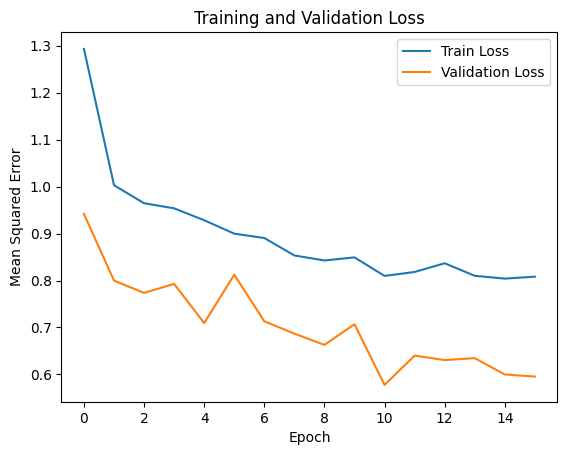

[I 2024-12-16 14:51:10,234] Trial 6 finished with value: 0.5694899974317801 and parameters: {'batch_size': 1, 'scaler_flag': 0, 'layer_1##dropout': 0.045000000000000005, 'layer_1##neuron_count': 219, 'layer_1##activation_type': 1, 'layer_2##dropout': 0.8550000000000001, 'layer_2##neuron_count': 244, 'layer_2##activation_type': 0, 'layer_3##NULL': 1.0, 'layer_3##dropout': 0.8250000000000001, 'layer_3##neuron_count': 28, 'layer_3##activation_type': 0, 'layer_4##NULL': 0.0, 'optimizer': 1, 'optimizer##option_1##learning_rate_schedule': 0, 'optimizer##option_1##learning_rate_schedule##option_0##learning_rate': 0.007525000000000001, 'optimizer##option_1##momentum': 0.5375, 'optimizer##option_1##nesterov': 1}. Best is trial 5 with value: 0.3594482541273132.


Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Test Mean Absolute Error (MAE): nan
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-12-16 14:51:20,164] Trial 7 finished with value: inf and parameters: {'batch_size': 2, 'scaler_flag': 1, 'layer_1##dropout': 0.8550000000000001, 'layer_1##neuron_count': 20, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.045000000000000005, 'layer_2##neuron_count': 20, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.0, 'layer_4##NULL': 1.0, 'layer_4##dropout': 0.675, 'layer_4##neuron_count': 194, 'layer_4##activation_type': 1, 'optimizer': 1, 'optimizer##option_1##learning_rate_schedule': 0, 'optimizer##option_1##learning_rate_schedule##option_0##learning_rate': 0.002575, 'optimizer##option_1##momentum': 0.9125, 'optimizer##option_1##nesterov': 0}. Best is trial 5 with value: 0.3594482541273132.


Invalid Test Mean Squared Error (MSE)
Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-16 14:51:22.192904: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 128 bytes spill stores, 128 bytes spill loads

2024-12-16 14:51:22.446956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 92 bytes spill stores, 92 bytes spill loads

2024-12-16 14:51:22.753627: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_f

192/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3092 - mae: 1.1148

2024-12-16 14:51:25.869800: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1330', 8 bytes spill stores, 8 bytes spill loads

2024-12-16 14:51:26.009881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 4 bytes spill stores, 4 bytes spill loads

2024-12-16 14:51:26.151675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1330', 16 bytes spill stores, 16 bytes spill loads

2024-12-16 14:51:26.153459: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1330', 4 bytes spill stores, 4 bytes spill loads

2024-12-16 14:51:26.208875: I external/local_xla/xla/stream_execut

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2437 - mae: 1.0960

2024-12-16 14:51:28.304515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 108 bytes spill stores, 108 bytes spill loads

2024-12-16 14:51:28.456147: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 72 bytes spill stores, 72 bytes spill loads

2024-12-16 14:51:28.541663: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 124 bytes spill stores, 192 bytes spill loads

2024-12-16 14:51:29.216692: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 708 bytes spill stores, 844 bytes spill loads

2024-12-16 14:51:29.245969: I external/local_xla/xla/stream_ex

207/207 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 2.2396 - mae: 1.0949 - val_loss: 0.6529 - val_mae: 0.5910
Epoch 2/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8076 - mae: 0.6694 - val_loss: 0.6755 - val_mae: 0.5781
Epoch 3/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7893 - mae: 0.6603 - val_loss: 0.5807 - val_mae: 0.5596
Epoch 4/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7629 - mae: 0.6426 - val_loss: 0.5776 - val_mae: 0.5436
Epoch 5/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7613 - mae: 0.6199 - val_loss: 0.5596 - val_mae: 0.5338
Epoch 6/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - mae: 0.6019 - val_loss: 0.5675 - val_mae: 0.5450
Epoch 7/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6843 - mae: 0.6105 - val_loss: 0.5559 - val_mae: 0.5255
Epoch 8/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5848 - mae: 0.5644 - val_loss: 0.5404 - val_mae: 0.5152
Epoch 9/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

2024-12-16 14:51:50.032345: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 176 bytes spill stores, 176 bytes spill loads



Test Mean Absolute Error (MAE): 0.44
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test Mean Squared Error (MSE): 0.40


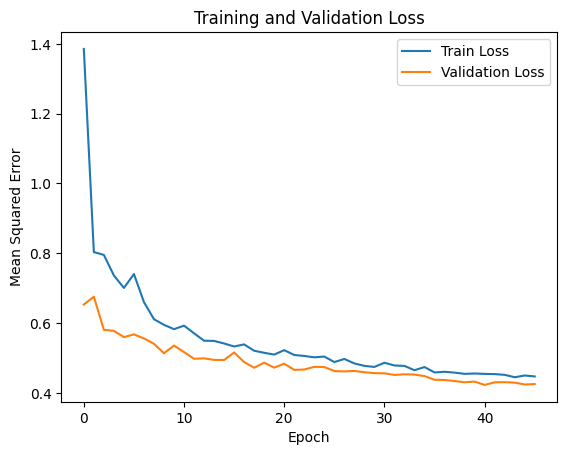

[I 2024-12-16 14:51:51,512] Trial 8 finished with value: 0.3992220489138272 and parameters: {'batch_size': 3, 'scaler_flag': 1, 'layer_1##dropout': 0.675, 'layer_1##neuron_count': 169, 'layer_1##activation_type': 1, 'layer_2##dropout': 0.315, 'layer_2##neuron_count': 70, 'layer_2##activation_type': 0, 'layer_3##NULL': 1.0, 'layer_3##dropout': 0.225, 'layer_3##neuron_count': 194, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.0, 'optimizer': 1, 'optimizer##option_1##learning_rate_schedule': 1, 'optimizer##option_1##learning_rate_schedule##option_1##initial_learning_rate': 0.0013375000000000001, 'optimizer##option_1##learning_rate_schedule##option_1##decay_steps': 8762.5, 'optimizer##option_1##learning_rate_schedule##option_1##decay_rate': 0.68375, 'optimizer##option_1##learning_rate_schedule##option_1##staircase': 0, 'optimizer##option_1##momentum': 0.8374999999999999, 'optimizer##option_1##nesterov': 0}. Best is trial 5 with value: 0.3594482541273132.


Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-16 14:51:53.375545: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 92 bytes spill stores, 92 bytes spill loads

2024-12-16 14:51:53.543259: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 236 bytes spill stores, 236 bytes spill loads

2024-12-16 14:51:53.581517: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_f

191/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0207 - mae: 1.0839

2024-12-16 14:51:56.018745: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 8 bytes spill stores, 8 bytes spill loads

2024-12-16 14:51:56.130382: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 32 bytes spill stores, 32 bytes spill loads

2024-12-16 14:51:56.171385: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 88 bytes spill stores, 88 bytes spill loads



207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9751 - mae: 1.0715

2024-12-16 14:51:58.133311: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 64 bytes spill stores, 64 bytes spill loads

2024-12-16 14:51:58.161499: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 124 bytes spill stores, 124 bytes spill loads

2024-12-16 14:51:58.194513: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 168 bytes spill stores, 168 bytes spill loads

2024-12-16 14:51:58.879293: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 648 bytes spill stores, 656 bytes spill loads

2024-12-16 14:52:00.143174: I external/local_xla/xla/stream_ex

207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 1.9725 - mae: 1.0707 - val_loss: 0.9925 - val_mae: 0.7734
Epoch 2/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9706 - mae: 0.7660 - val_loss: 0.6274 - val_mae: 0.6124
Epoch 3/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7150 - mae: 0.6405 - val_loss: 0.6162 - val_mae: 0.6196
Epoch 4/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - mae: 0.6138 - val_loss: 0.5647 - val_mae: 0.5499
Epoch 5/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6348 - mae: 0.5949 - val_loss: 0.5600 - val_mae: 0.5428
Epoch 6/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6195 - mae: 0.5871 - val_loss: 0.5523 - val_mae: 0.5314
Epoch 7/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6233 - mae: 0.5849 - val_loss: 0.5356 - val_mae: 0.5356
Epoch 8/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6013 - mae: 0.5760 - val_loss: 0.5314 - val_mae: 0.5290
Epoch 9/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

2024-12-16 14:52:26.995459: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 172 bytes spill stores, 172 bytes spill loads



Test Mean Absolute Error (MAE): 0.49
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test Mean Squared Error (MSE): 0.47


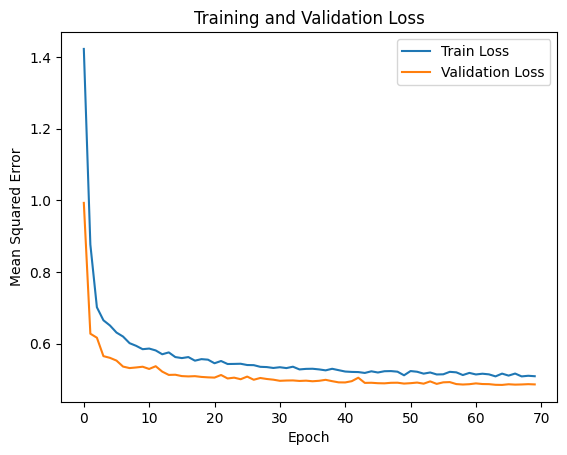

[I 2024-12-16 14:52:28,142] Trial 9 finished with value: 0.474314872325051 and parameters: {'batch_size': 3, 'scaler_flag': 0, 'layer_1##dropout': 0.225, 'layer_1##neuron_count': 70, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.5850000000000001, 'layer_2##neuron_count': 194, 'layer_2##activation_type': 0, 'layer_3##NULL': 0.0, 'layer_4##NULL': 1.0, 'layer_4##dropout': 0.225, 'layer_4##neuron_count': 70, 'layer_4##activation_type': 0, 'optimizer': 1, 'optimizer##option_1##learning_rate_schedule': 1, 'optimizer##option_1##learning_rate_schedule##option_1##initial_learning_rate': 0.0038125000000000004, 'optimizer##option_1##learning_rate_schedule##option_1##decay_steps': 1337.5, 'optimizer##option_1##learning_rate_schedule##option_1##decay_rate': 0.80625, 'optimizer##option_1##learning_rate_schedule##option_1##staircase': 1, 'optimizer##option_1##momentum': 0.6125, 'optimizer##option_1##nesterov': 1}. Best is trial 5 with value: 0.3594482541273132.


Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.1677 - mae: 1.3074 - val_loss: 1.3267 - val_mae: 0.8544
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6292 - mae: 0.9058 - val_loss: 1.2965 - val_mae: 0.8583
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4056 - mae: 0.8942 - val_loss: 1.2842 - val_mae: 0.8546
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4531 - mae: 0.9006 - val_loss: 1.2863 - val_mae: 0.8518
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3278 - mae: 0.8673 - val_loss: 1.2302 - val_mae: 0.8411
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6051 - mae: 0.8902 - val_loss: 1.2389 - val_mae: 0.8380
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3177 - mae: 0.8708 - val_loss: 1.1967 - val_mae: 0.8267
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2703 - mae: 0.8414 - val_loss: 1.1796 - val_mae: 0.8226
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss:

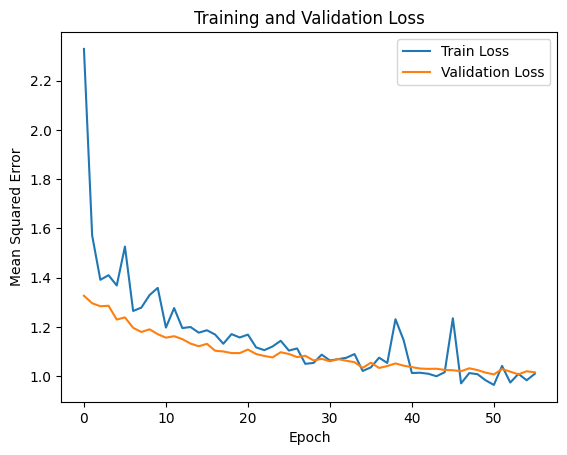

[I 2024-12-16 14:54:11,801] Trial 10 finished with value: 0.9673160668046834 and parameters: {'batch_size': 1, 'scaler_flag': 1, 'layer_1##dropout': 0.28528765750395335, 'layer_1##neuron_count': 151, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.6621245388074207, 'layer_2##neuron_count': 105, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.29352163594018954, 'layer_3##dropout': 0.88159222124232, 'layer_3##neuron_count': 25, 'layer_3##activation_type': 0, 'layer_4##NULL': 0.6745911305716814, 'layer_4##dropout': 0.7830757687355242, 'layer_4##neuron_count': 249, 'layer_4##activation_type': 1, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8403816704723917, 'optimizer##option_0##beta_2': 0.9600344130833336, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.0006330737293833944, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 573.9975240272342,

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5795 - mae: 1.0023

2024-12-16 14:54:18.316808: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 380 bytes spill stores, 412 bytes spill loads

2024-12-16 14:54:18.747277: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 376 bytes spill stores, 408 bytes spill loads

2024-12-16 14:54:20.073568: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 256 bytes spill stores, 256 bytes spill loads

2024-12-16 14:54:20.832391: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 164 bytes spill stores, 164 bytes spill loads



413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2.5773 - mae: 1.0020 - val_loss: 0.7565 - val_mae: 0.5892
Epoch 2/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0767 - mae: 0.7488 - val_loss: 0.6798 - val_mae: 0.5555
Epoch 3/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9170 - mae: 0.6900 - val_loss: 0.6548 - val_mae: 0.5455
Epoch 4/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8145 - mae: 0.6532 - val_loss: 0.6110 - val_mae: 0.5257
Epoch 5/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7486 - mae: 0.6241 - val_loss: 0.5531 - val_mae: 0.5059
Epoch 6/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7507 - mae: 0.6194 - val_loss: 0.5827 - val_mae: 0.5149
Epoch 7/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7235 - mae: 0.5985 - val_loss: 0.5594 - val_mae: 0.5089
Epoch 8/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6588 - mae: 0.5798 - val_loss: 0.5589 - val_mae: 0.5084
Epoch 9/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss

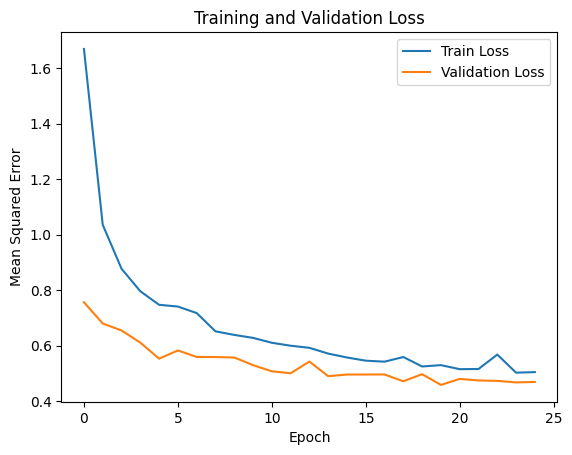

[I 2024-12-16 14:54:42,741] Trial 11 finished with value: 0.42438028018574164 and parameters: {'batch_size': 2, 'scaler_flag': 1, 'layer_1##dropout': 0.6548349109518694, 'layer_1##neuron_count': 154, 'layer_1##activation_type': 1, 'layer_2##dropout': 0.33153076671428644, 'layer_2##neuron_count': 80, 'layer_2##activation_type': 0, 'layer_3##NULL': 0.6955598683468932, 'layer_3##dropout': 0.14497965887541048, 'layer_3##neuron_count': 228, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.29808469857660225, 'layer_4##dropout': 0.8956414382730248, 'layer_4##neuron_count': 256, 'layer_4##activation_type': 1, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8850494732780811, 'optimizer##option_0##beta_2': 0.9083267400685866, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.002046632996618073, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 2265.0817251413

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-16 14:54:45.627742: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1713', 60 bytes spill stores, 60 bytes spill loads

2024-12-16 14:54:45.912010: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1713', 524 bytes spill stores, 524 bytes spill loads

2024-12-16 14:54:47.915040: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_f

187/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8295 - mae: 1.2704

2024-12-16 14:54:51.270830: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1713', 56 bytes spill stores, 56 bytes spill loads

2024-12-16 14:54:51.943301: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1713', 56 bytes spill stores, 56 bytes spill loads

2024-12-16 14:54:52.100116: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1745', 56 bytes spill stores, 56 bytes spill loads

2024-12-16 14:54:52.235784: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1745', 56 bytes spill stores, 56 bytes spill loads



207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.7279 - mae: 1.2404

2024-12-16 14:54:54.768814: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 76 bytes spill stores, 76 bytes spill loads

2024-12-16 14:54:55.008942: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 92 bytes spill stores, 92 bytes spill loads

2024-12-16 14:54:55.492305: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 24 bytes spill stores, 32 bytes spill loads

2024-12-16 14:54:55.541724: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 112 bytes spill stores, 112 bytes spill loads

2024-12-16 14:54:56.437662: I external/local_xla/xla/stream_execut

207/207 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 2.7232 - mae: 1.2390 - val_loss: 0.7682 - val_mae: 0.6390
Epoch 2/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9581 - mae: 0.7382 - val_loss: 0.6731 - val_mae: 0.5881
Epoch 3/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8808 - mae: 0.6957 - val_loss: 0.6421 - val_mae: 0.5744
Epoch 4/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8226 - mae: 0.6754 - val_loss: 0.6125 - val_mae: 0.5625
Epoch 5/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7898 - mae: 0.6600 - val_loss: 0.5961 - val_mae: 0.5552
Epoch 6/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7888 - mae: 0.6518 - val_loss: 0.5877 - val_mae: 0.5448
Epoch 7/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7107 - mae: 0.6248 - val_loss: 0.5738 - val_mae: 0.5387
Epoch 8/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6997 - mae: 0.6186 - val_loss: 0.5621 - val_mae: 0.5332
Epoch 9/250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

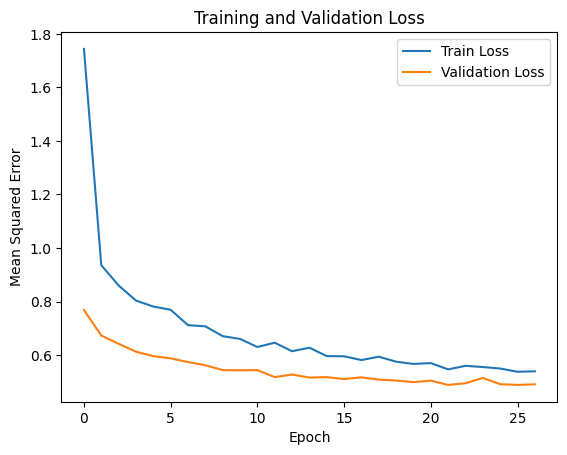

[I 2024-12-16 14:55:15,651] Trial 12 finished with value: 0.46865608650399637 and parameters: {'batch_size': 3, 'scaler_flag': 1, 'layer_1##dropout': 0.3756281530622084, 'layer_1##neuron_count': 173, 'layer_1##activation_type': 1, 'layer_2##dropout': 0.31265329116937995, 'layer_2##neuron_count': 67, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.5268511275099959, 'layer_3##dropout': 0.2899553596415928, 'layer_3##neuron_count': 163, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.6240398500403963, 'layer_4##dropout': 0.5928486822161535, 'layer_4##neuron_count': 191, 'layer_4##activation_type': 1, 'optimizer': 1, 'optimizer##option_1##learning_rate_schedule': 1, 'optimizer##option_1##learning_rate_schedule##option_1##initial_learning_rate': 0.00042335669619107533, 'optimizer##option_1##learning_rate_schedule##option_1##decay_steps': 9430.278516900742, 'optimizer##option_1##learning_rate_schedule##option_1##decay_rate': 0.615486749099222, 'optimizer##option_1##learning_rate_schedule#

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 1.1933 - mae: 0.7807 - val_loss: 0.5962 - val_mae: 0.5281
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6078 - mae: 0.5687 - val_loss: 0.5402 - val_mae: 0.5131
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5480 - mae: 0.5355 - val_loss: 0.4703 - val_mae: 0.4873
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5018 - mae: 0.5100 - val_loss: 0.4622 - val_mae: 0.4851
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4739 - mae: 0.4985 - val_loss: 0.5094 - val_mae: 0.4916
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4850 - mae: 0.4947 - val_loss: 0.4487 - val_mae: 0.4770
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4635 - mae: 0.4900 - val_loss: 0.4082 - val_mae: 0.4730
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4288 - mae: 0.4740 - val_loss: 0.4164 - val_mae: 0.4680
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - los

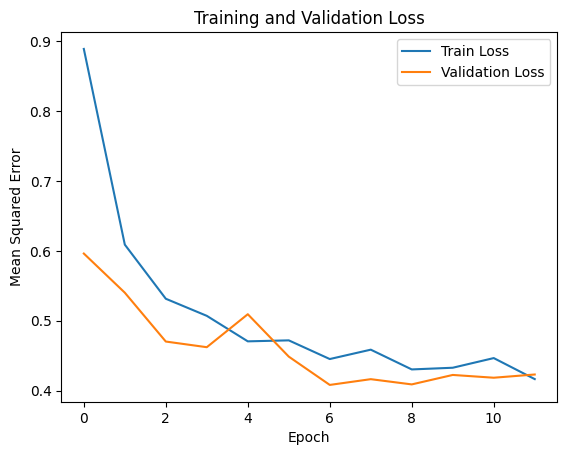

[I 2024-12-16 14:55:49,915] Trial 13 finished with value: 0.3881379983850011 and parameters: {'batch_size': 1, 'scaler_flag': 1, 'layer_1##dropout': 0.6856505467604787, 'layer_1##neuron_count': 116, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.5731838115073757, 'layer_2##neuron_count': 129, 'layer_2##activation_type': 0, 'layer_3##NULL': 0.23939066560126743, 'layer_3##dropout': 0.2301754275741717, 'layer_3##neuron_count': 195, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.2942252217172341, 'layer_4##dropout': 0.41563722109789414, 'layer_4##neuron_count': 205, 'layer_4##activation_type': 0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8848504231269378, 'optimizer##option_0##beta_2': 0.9154551104364835, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.004611740332928445, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 4782.00595247826

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0832 - mae: 0.7389

2024-12-16 14:55:57.195920: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 4 bytes spill stores, 4 bytes spill loads

2024-12-16 14:55:59.990825: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 264 bytes spill stores, 264 bytes spill loads



826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.0829 - mae: 0.7388 - val_loss: 0.5440 - val_mae: 0.4991
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5680 - mae: 0.5465 - val_loss: 0.4961 - val_mae: 0.4888
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5073 - mae: 0.5186 - val_loss: 0.5088 - val_mae: 0.4896
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4797 - mae: 0.5007 - val_loss: 0.5092 - val_mae: 0.4855
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4547 - mae: 0.4819 - val_loss: 0.5225 - val_mae: 0.4886
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4352 - mae: 0.4767 - val_loss: 0.4317 - val_mae: 0.4528
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4371 - mae: 0.4725 - val_loss: 0.4143 - val_mae: 0.4476
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4181 - mae: 0.4647 - val_loss: 0.4347 - val_mae: 0.4506
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss

2024-12-16 14:57:00.927211: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 296 bytes spill stores, 360 bytes spill loads



Test Mean Absolute Error (MAE): 0.41
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test Mean Squared Error (MSE): 0.34


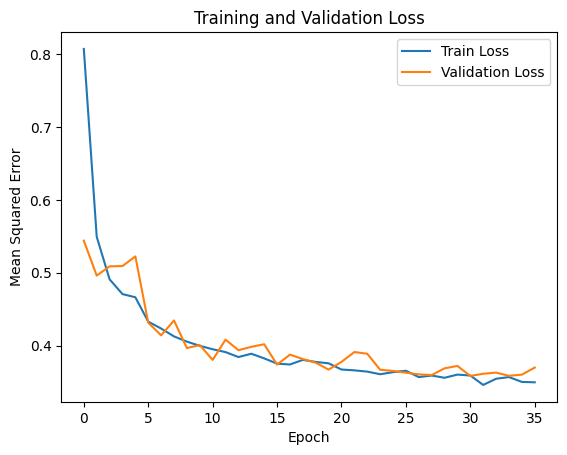

[I 2024-12-16 14:57:02,341] Trial 14 finished with value: 0.3409088277533893 and parameters: {'batch_size': 1, 'scaler_flag': 1, 'layer_1##dropout': 0.5103058267935531, 'layer_1##neuron_count': 111, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.6633308193555612, 'layer_2##neuron_count': 133, 'layer_2##activation_type': 0, 'layer_3##NULL': 0.20851073762092331, 'layer_3##dropout': 0.006282909089399269, 'layer_3##neuron_count': 110, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.31827571673791133, 'layer_4##dropout': 0.3937679582503115, 'layer_4##neuron_count': 205, 'layer_4##activation_type': 0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8811962987675341, 'optimizer##option_0##beta_2': 0.9080183109661594, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.0043256433690905365, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 4437.54926174

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1652/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2732 - mae: 0.7702

2024-12-16 14:57:10.545218: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 312 bytes spill stores, 404 bytes spill loads

2024-12-16 14:57:13.482550: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 312 bytes spill stores, 404 bytes spill loads



1652/1652 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.2729 - mae: 0.7701 - val_loss: 0.5832 - val_mae: 0.5447
Epoch 2/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5869 - mae: 0.5603 - val_loss: 0.5738 - val_mae: 0.5221
Epoch 3/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5353 - mae: 0.5328 - val_loss: 0.4857 - val_mae: 0.4847
Epoch 4/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4827 - mae: 0.5010 - val_loss: 0.4811 - val_mae: 0.4811
Epoch 5/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5203 - mae: 0.5062 - val_loss: 0.5280 - val_mae: 0.5008
Epoch 6/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4631 - mae: 0.4893 - val_loss: 0.4408 - val_mae: 0.4671
Epoch 7/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4492 - mae: 0.4825 - val_loss: 0.4429 - val_mae: 0.4636
Epoch 8/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4373 - mae: 0.4803 - val_loss: 0.4537 - val_mae: 0.4717
Epoch 9/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-16 14:58:16.496880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 516 bytes spill stores, 552 bytes spill loads



Test Mean Absolute Error (MAE): 0.44
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test Mean Squared Error (MSE): 0.38


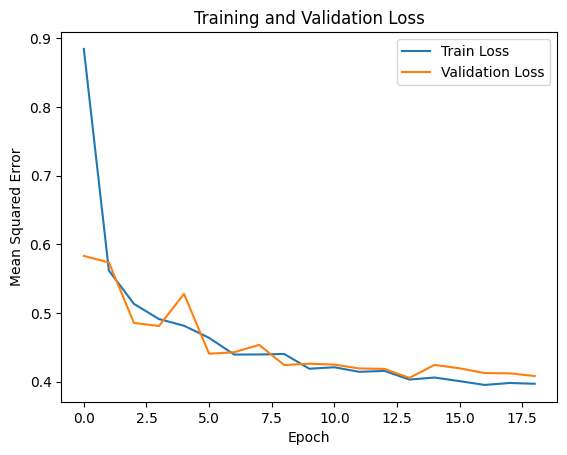

[I 2024-12-16 14:58:18,522] Trial 15 finished with value: 0.3799049908939444 and parameters: {'batch_size': 0, 'scaler_flag': 1, 'layer_1##dropout': 0.5042527285222735, 'layer_1##neuron_count': 82, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.7313859075795356, 'layer_2##neuron_count': 136, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.2054237189824313, 'layer_3##dropout': 0.02370252589689842, 'layer_3##neuron_count': 100, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.36021339175890293, 'layer_4##dropout': 0.2634044636826674, 'layer_4##neuron_count': 221, 'layer_4##activation_type': 0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8616117428899965, 'optimizer##option_0##beta_2': 0.931865124090041, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.003657137355670349, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 4235.893627913079,

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.2491 - mae: 0.9766 - val_loss: 1.1101 - val_mae: 0.7557
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8536 - mae: 0.6784 - val_loss: 0.9714 - val_mae: 0.7011
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7390 - mae: 0.6221 - val_loss: 0.9088 - val_mae: 0.6765
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6462 - mae: 0.5879 - val_loss: 0.9361 - val_mae: 0.6804
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6780 - mae: 0.5800 - val_loss: 0.9341 - val_mae: 0.6748
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6197 - mae: 0.5718 - val_loss: 0.9015 - val_mae: 0.6595
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5977 - mae: 0.5684 - val_loss: 0.8181 - val_mae: 0.6284
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5589 - mae: 0.5502 - val_loss: 0.8380 - val_mae: 0.6328
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss

2024-12-16 14:59:01.009275: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 24 bytes spill stores, 24 bytes spill loads



Test Mean Absolute Error (MAE): 0.60
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test Mean Squared Error (MSE): 0.74


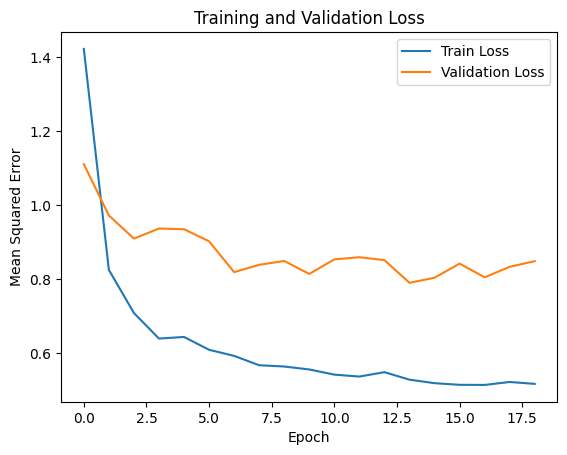

[I 2024-12-16 14:59:02,628] Trial 16 finished with value: 0.7442885701216396 and parameters: {'batch_size': 1, 'scaler_flag': 1, 'layer_1##dropout': 0.28431630352344683, 'layer_1##neuron_count': 118, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.8702982825528329, 'layer_2##neuron_count': 176, 'layer_2##activation_type': 0, 'layer_3##NULL': 0.1535570991714978, 'layer_3##dropout': 0.5240727829591408, 'layer_3##neuron_count': 67, 'layer_3##activation_type': 0, 'layer_4##NULL': 0.7978598079491238, 'layer_4##dropout': 0.6945804409081326, 'layer_4##neuron_count': 155, 'layer_4##activation_type': 1, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.9219668396807389, 'optimizer##option_0##beta_2': 0.8723251548656424, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.006813661349749048, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 2961.2418608208636

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4139 - mae: 0.8403

2024-12-16 14:59:08.572737: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 144 bytes spill stores, 144 bytes spill loads

2024-12-16 14:59:10.732878: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 124 bytes spill stores, 124 bytes spill loads



413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 1.4133 - mae: 0.8401 - val_loss: 0.6308 - val_mae: 0.5581
Epoch 2/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8979 - mae: 0.6792 - val_loss: 0.5474 - val_mae: 0.5614
Epoch 3/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7000 - mae: 0.6226 - val_loss: 0.5807 - val_mae: 0.5724
Epoch 4/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7023 - mae: 0.6281 - val_loss: 0.5926 - val_mae: 0.5718
Epoch 5/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7476 - mae: 0.6333 - val_loss: 0.5788 - val_mae: 0.5726
Epoch 6/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7058 - mae: 0.6235 - val_loss: 0.5405 - val_mae: 0.5605
Epoch 7/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7175 - mae: 0.6377 - val_loss: 0.5980 - val_mae: 0.5763
Epoch 8/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7834 - mae: 0.6470 - val_loss: 0.5329 - val_mae: 0.5507
Epoch 9/250
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss

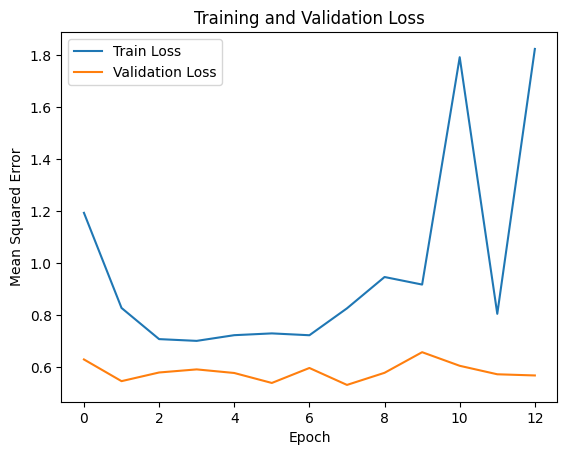

[I 2024-12-16 14:59:22,446] Trial 17 finished with value: 0.5145364251535093 and parameters: {'batch_size': 2, 'scaler_flag': 1, 'layer_1##dropout': 0.3931356854632993, 'layer_1##neuron_count': 196, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.6313095079485312, 'layer_2##neuron_count': 114, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.3692068927967844, 'layer_3##dropout': 0.6757127202561353, 'layer_3##neuron_count': 126, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.4780701377548513, 'layer_4##dropout': 0.30976562498921456, 'layer_4##neuron_count': 226, 'layer_4##activation_type': 0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8023047861399418, 'optimizer##option_0##beta_2': 0.997970289740269, 'optimizer##option_0##amsgrad': 0, 'optimizer##option_0##learning_rate_schedule': 0, 'optimizer##option_0##learning_rate_schedule##option_0##learning_rate': 0.009980398712280646}. Best is trial 14 with value: 0.3409088277533893.


Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1652/1652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2157 - mae: 0.7647

2024-12-16 14:59:30.249311: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 224 bytes spill stores, 224 bytes spill loads

2024-12-16 14:59:32.211493: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 224 bytes spill stores, 224 bytes spill loads



1652/1652 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.2155 - mae: 0.7646 - val_loss: 0.5717 - val_mae: 0.5291
Epoch 2/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6774 - mae: 0.5851 - val_loss: 0.5427 - val_mae: 0.5014
Epoch 3/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6103 - mae: 0.5476 - val_loss: 0.5485 - val_mae: 0.5004
Epoch 4/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5152 - mae: 0.5180 - val_loss: 0.4987 - val_mae: 0.4878
Epoch 5/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5169 - mae: 0.5253 - val_loss: 0.4690 - val_mae: 0.4756
Epoch 6/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5040 - mae: 0.5187 - val_loss: 0.5089 - val_mae: 0.4885
Epoch 7/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4872 - mae: 0.5047 - val_loss: 0.4779 - val_mae: 0.4766
Epoch 8/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4868 - mae: 0.5074 - val_loss: 0.4934 - val_mae: 0.4831
Epoch 9/250
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-16 15:00:14.334014: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 484 bytes spill stores, 520 bytes spill loads



Test Mean Absolute Error (MAE): 0.46
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
Test Mean Squared Error (MSE): 0.44


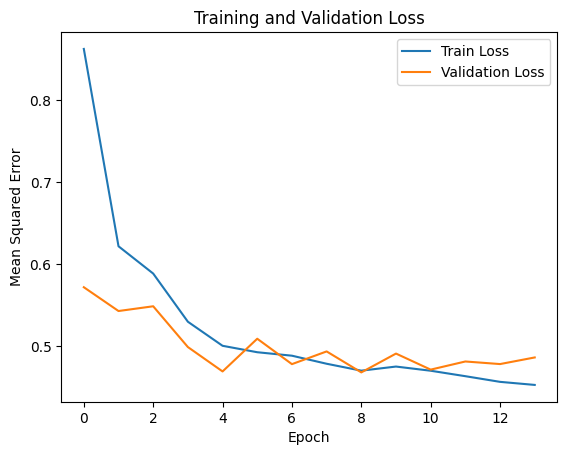

[I 2024-12-16 15:00:15,875] Trial 18 finished with value: 0.4379037950488316 and parameters: {'batch_size': 0, 'scaler_flag': 1, 'layer_1##dropout': 0.5656102828067695, 'layer_1##neuron_count': 52, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.48469591379724797, 'layer_2##neuron_count': 161, 'layer_2##activation_type': 0, 'layer_3##NULL': 0.12010609670028566, 'layer_4##NULL': 0.8232878476540542, 'layer_4##dropout': 0.10621343446448878, 'layer_4##neuron_count': 160, 'layer_4##activation_type': 1, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.9209799857870935, 'optimizer##option_0##beta_2': 0.8735008777754878, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.0031151759493258484, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 6662.432929682604, 'optimizer##option_0##learning_rate_schedule##option_1##decay_rate': 0.6014192794946949, 'optimiz

Epoch 1/250


/home/neil/projects-alt/raxpy/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3238 - mae: 0.7646

2024-12-16 15:00:23.253861: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 36 bytes spill stores, 36 bytes spill loads

2024-12-16 15:00:23.385791: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 192 bytes spill stores, 192 bytes spill loads

2024-12-16 15:00:25.157022: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 264 bytes spill stores, 264 bytes spill loads

2024-12-16 15:00:25.275068: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 204 bytes spill stores, 204 bytes spill loads



826/826 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.3233 - mae: 0.7645 - val_loss: 0.5278 - val_mae: 0.5068
Epoch 2/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5489 - mae: 0.5338 - val_loss: 0.5023 - val_mae: 0.5076
Epoch 3/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4858 - mae: 0.5111 - val_loss: 0.4850 - val_mae: 0.5126
Epoch 4/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4542 - mae: 0.4912 - val_loss: 0.4677 - val_mae: 0.4954
Epoch 5/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4416 - mae: 0.4851 - val_loss: 0.4695 - val_mae: 0.4959
Epoch 6/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4293 - mae: 0.4814 - val_loss: 0.4523 - val_mae: 0.4794
Epoch 7/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4150 - mae: 0.4709 - val_loss: 0.4545 - val_mae: 0.4933
Epoch 8/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4101 - mae: 0.4650 - val_loss: 0.4153 - val_mae: 0.4676
Epoch 9/250
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss

2024-12-16 15:00:59.566316: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 232 bytes spill stores, 232 bytes spill loads

2024-12-16 15:00:59.956853: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 412 bytes spill stores, 444 bytes spill loads



Test Mean Absolute Error (MAE): 0.44
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test Mean Squared Error (MSE): 0.36


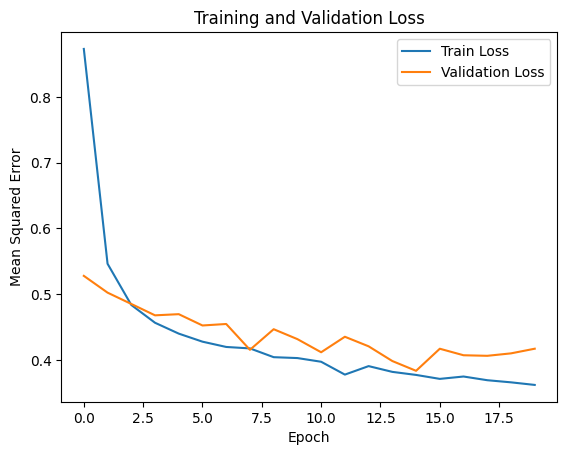

[I 2024-12-16 15:01:01,484] Trial 19 finished with value: 0.36144092605707584 and parameters: {'batch_size': 1, 'scaler_flag': 1, 'layer_1##dropout': 0.002165370827062252, 'layer_1##neuron_count': 134, 'layer_1##activation_type': 0, 'layer_2##dropout': 0.754879288153362, 'layer_2##neuron_count': 194, 'layer_2##activation_type': 1, 'layer_3##NULL': 0.4310576240968155, 'layer_3##dropout': 0.39844399325917873, 'layer_3##neuron_count': 68, 'layer_3##activation_type': 1, 'layer_4##NULL': 0.17330167600329782, 'layer_4##dropout': 0.5010966747082753, 'layer_4##neuron_count': 114, 'layer_4##activation_type': 0, 'optimizer': 0, 'optimizer##option_0##beta_1': 0.8544197573541787, 'optimizer##option_0##beta_2': 0.9442619789606724, 'optimizer##option_0##amsgrad': 1, 'optimizer##option_0##learning_rate_schedule': 1, 'optimizer##option_0##learning_rate_schedule##option_1##initial_learning_rate': 0.009777563381335026, 'optimizer##option_0##learning_rate_schedule##option_1##decay_steps': 9611.5303570083

In [4]:
explore_point_count = 10
exploit_point_count = 10
best_point, hp_f = optimize(init_sampling_points=explore_point_count, designer=raxpy.generate_design, f=train, max_points=exploit_point_count+explore_point_count)

In [ ]:

def optmize_f(
    init_sample_points:Annotated[float, raxpy.Integer(lb=10, ub=100)],
    opt_points:Annotated[float, raxpy.Integer(lb=5, ub=100)],
):

    max_points = init_sample_points + opt_points
    point_1,fn = optimize(init_sampling_points=init_sample_points, designer=raxpy.generate_design, f=train, max_points=opt_points)
    point_2,fn = optimize(init_sampling_points=init_sample_points, designer=raxpy.generate_random_design, f=train, max_points=opt_points)
    point_3,fn = optimize(init_sampling_points=0, designer=raxpy.generate_random_design, f=train, max_points=max_points)

    p1_b = fn(point_1)
    p2_b = fn(point_2)
    p3_b = fn(point_3)

    return p1_b, p2_b, p3_b